In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math


In [3]:
dfT=pd.read_csv('Temp.csv')

In [4]:
dfT

,date,Temperature
0,2015-02-04 17:51:00,23.18
1,2015-02-04 17:51:59,23.15
2,2015-02-04 17:53:00,23.15
3,2015-02-04 17:54:00,23.15
4,2015-02-04 17:55:00,23.10
...,...,...
8138,2015-02-10 09:29:00,21.05
8139,2015-02-10 09:29:59,21.05
8140,2015-02-10 09:30:59,21.10
8141,2015-02-10 09:32:00,21.10


In [6]:
df1=dfT.reset_index()['Temperature']

In [7]:
df1

0       23.18
1       23.15
2       23.15
3       23.15
4       23.10
        ...  
8138    21.05
8139    21.05
8140    21.10
8141    21.10
8142    21.10
Name: Temperature, Length: 8143, dtype: float64

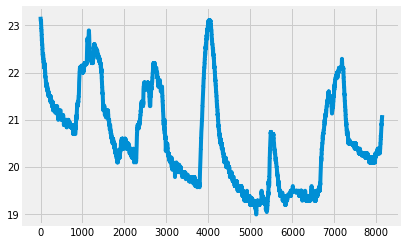

In [8]:
df1.plot()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:]

In [13]:
len(train_data)

6514

In [14]:
#Creating Dataset
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+ time_step,0])
    return np.array(dataX),np.array(dataY)    

In [15]:
time_step=10
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [16]:
print(X_train.shape,y_train.shape)

(6503, 10) (6503,)


In [17]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [18]:
#Creating a LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler

In [19]:
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [20]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(time_step,1),name='Input_Layer'))
model.add(LSTM(32,return_sequences=True,recurrent_dropout=0.4,name='LSTM1'))
model.add(LSTM(64,return_sequences=True,recurrent_dropout=0.4,name='LSTM2'))
model.add(LSTM(64,recurrent_dropout=0.2,name='LSTM3'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (LSTM)           (None, 10, 64)            16896     
_________________________________________________________________
LSTM1 (LSTM)                 (None, 10, 32)            12416     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 10, 64)            24832     
_________________________________________________________________
LSTM3 (LSTM)                 (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 87,233
Trainable params: 87,233
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25,batch_size=32,verbose=1,callbacks=[LearningRateScheduler,early])

Train on 6503 samples, validate on 1618 samples
Epoch 1/25
6503/6503 [==============================] - 29s 4ms/sample - loss: 0.0477 - val_loss: 4.1020e-04
Epoch 2/25
6503/6503 [==============================] - 19s 3ms/sample - loss: 0.0014 - val_loss: 4.1567e-04
Epoch 3/25
6503/6503 [==============================] - 19s 3ms/sample - loss: 9.8548e-04 - val_loss: 3.0438e-04
Epoch 4/25
6503/6503 [==============================] - 18s 3ms/sample - loss: 6.7828e-04 - val_loss: 2.6482e-04
Epoch 5/25
6503/6503 [==============================] - 19s 3ms/sample - loss: 5.5568e-04 - val_loss: 2.4477e-04
Epoch 6/25
6503/6503 [==============================] - 19s 3ms/sample - loss: 4.7282e-04 - val_loss: 2.6050e-04
Epoch 7/25
6503/6503 [==============================] - 20s 3ms/sample - loss: 4.2045e-04 - val_loss: 3.9532e-04
Epoch 8/25
6503/6503 [==============================] - 19s 3ms/sample - loss: 4.0184e-04 - val_loss: 2.4331e-04
Epoch 9/25
6503/6503 [==============================] - 

In [24]:
test_predict=model.predict(X_test)

In [25]:
test_predict=scaler.inverse_transform(test_predict)

In [28]:
math.sqrt(mean_squared_error(y_test,test_predict))

20.281058277232674

In [29]:
test_predict

array([[19.396378],
       [19.395535],
       [19.39446 ],
       ...,
       [20.992308],
       [21.003292],
       [21.00731 ]], dtype=float32)

In [32]:
df=pd.DataFrame(test_predict)

In [33]:
df

,0
0,19.396378
1,19.395535
2,19.394461
3,19.392784
4,19.389973
...,...
1613,20.953428
1614,20.974552
1615,20.992308
1616,21.003292


In [34]:
df.to_csv('TempPred.csv')

In [1]:
#Similarly Running An LSTM Network For the other 3 features